In [23]:
# import things
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from pathlib import Path
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import IOUScore, FScore

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import cv2 # Used for pixel counting
from pathlib import Path # Used for pixel counting
import shutil # Used for directory cleanup
import gc # For garbage collection
import random # For dataset sampling in visualization utilities

# Import necessary components from segmentation_models
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import IOUScore, FScore

# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalized before attempting this task.

# --- Configuration ---
patch_size = 256
batch_size = 8 # Adjusted batch size for better gradient flow and memory management
# Ensure this path is correct and accessible from where you run the script
patch_dir = r"C:\BUAS\retake\task_4_full_datasets\simple_filtered_dataset"

ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"  # <-- TRANSFER LEARNING

# Learning rates for the two phases of training
LR_WARMUP = 5e-4 # Increased warm-up learning rate
LR_FINETUNE = 1e-4

# Number of epochs for each phase
EPOCHS_WARMUP = 5
EPOCHS_FINETUNE = 25

# --- Custom F1 Score Metric (using Keras backend directly for illustration) ---
# Note: FScore from segmentation_models is generally preferred for robustness.
# This custom f1 is included as per your original code.
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon()) # Add K.epsilon() for numerical stability
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon()) # Add K.epsilon() for numerical stability
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    # Add K.epsilon() to the final denominator for numerical stability
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# --- Weighted Binary Cross-Entropy Loss Function ---
def weighted_bce_loss(zero_weight=1.0, one_weight=1.0): # Default weights, will be updated
    def loss(y_true, y_pred):
        # Calculate weights per pixel based on y_true
        weights = y_true * one_weight + (1. - y_true) * zero_weight
        bce = K.binary_crossentropy(y_true, y_pred)
        return K.mean(bce * weights) # Apply weights to BCE
    return loss

# --- Pixel Counting for Class Weights ---
# This section calculates the necessary weights for the weighted_bce_loss
train_masks_path_for_counting = Path(f'{patch_dir}/train_masks/train')
mask_files_for_counting = [f for f in train_masks_path_for_counting.glob("*.tif")]

total_foreground_pixels = 0
total_background_pixels = 0

print(f"Calculating pixel counts from {len(mask_files_for_counting)} training masks for class weighting...")

for mask_file in mask_files_for_counting:
    mask = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Warning: Could not read mask file {mask_file.name}. Skipping for counting.")
        continue
    
    # Ensure mask is strictly binary (0 or 1) for accurate counting
    binary_mask = (mask > 0).astype(np.uint8) 

    # Use int64 for summation to prevent overflow with large datasets
    foreground_count = np.sum(binary_mask == 1, dtype=np.int64)
    background_count = np.sum(binary_mask == 0, dtype=np.int64)
    
    total_foreground_pixels += foreground_count
    total_background_pixels += background_count

total_pixels = total_foreground_pixels + total_background_pixels

print(f"Total foreground pixels (roots): {total_foreground_pixels}")
print(f"Total background pixels: {total_background_pixels}")
print(f"Total pixels processed: {total_pixels}")

# Calculate `zero_weight` and `one_weight` based on pixel distribution
# This heuristic assigns higher weight to the minority class (foreground/roots)
if total_foreground_pixels > 0 and total_background_pixels > 0:
    # `one_weight` (for foreground) is scaled by the inverse ratio of its frequency to background
    calculated_one_weight = total_background_pixels / total_foreground_pixels
    # `zero_weight` (for background) can be 1.0 or smaller to further de-emphasize background
    calculated_zero_weight = 1.0 # Can be tuned, e.g., 0.1 or 0.5
    
    print(f"\nCalculated Weights for weighted_bce_loss:")
    print(f"  zero_weight (for background): {calculated_zero_weight:.4f}")
    print(f"  one_weight (for foreground): {calculated_one_weight:.4f}")
else:
    print("\nWarning: Foreground or background pixels are missing in training masks. Cannot calculate robust weights. Using default weights (1.0, 1.0).")
    calculated_zero_weight = 1.0
    calculated_one_weight = 1.0

# --- Data Generators Setup ---
# Preprocessing function for ResNet backbone (converts images to ResNet's expected input format)
preprocess_input = get_preprocessing(ENCODER)

# Training images: RGB, apply ResNet preprocessing
train_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb', # Images must be RGB for ImageNet pre-trained ResNet
    seed=42)

# Training masks: Grayscale, rescale to [0,1], then hard-binarize to {0.0, 1.0}
train_mask_datagen = ImageDataGenerator(
    rescale=1./255, # Rescales pixel values to [0, 1]
    preprocessing_function=lambda x: (x > 0.5).astype('float32') # Forces values to be strictly 0.0 or 1.0
)
train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale', # Masks are single channel
    seed=42)

# Paired generator to yield (image, mask) pairs
def paired_generator(img_gen, mask_gen):
    while True:
        imgs = next(img_gen)
        msks = next(mask_gen)       # shape (B, H, W, 1)
        yield imgs, msks

train_generator = paired_generator(train_image_generator, train_mask_generator)

# Validation images: RGB, apply ResNet preprocessing
val_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    seed=42
)

# Validation masks: Grayscale, rescale to [0,1], then hard-binarize
val_mask_datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=lambda x: (x > 0.5).astype('float32')
)
val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = paired_generator(val_image_generator, val_mask_generator)

# --- Model Building and Compilation (Warm-up Phase) ---
print("\n--- Building Model (Warm-up Phase: Encoder Frozen) ---")
model = Unet(
    backbone_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS, # Use ImageNet pre-trained weights
    classes=1, # Output classes (1 for binary segmentation)
    activation='sigmoid', # Sigmoid for binary segmentation
    input_shape=(patch_size, patch_size, 3) # Input shape for RGB images
)

# Freeze encoder layers for warm-up
for layer in model.layers:
    if "backbone" in layer.name or "encoder" in layer.name:
        layer.trainable = False

# REQUIREMENT: Model summary must be visible
print("\n=== Model Summary (encoder frozen for warm-up) ===\n")
model.summary()

# Use metrics from segmentation_models for robustness
iou_metric = IOUScore(threshold=0.5)
f1_metric = FScore(beta=1.0, threshold=0.5)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_WARMUP),
    loss=weighted_bce_loss(zero_weight=calculated_zero_weight, one_weight=calculated_one_weight), # Use calculated weighted loss
    metrics=[iou_metric, f1_metric]
)

# Callbacks for warm-up phase
callbacks_warmup = [
    ModelCheckpoint(
        "unet_resnet34_imagenet_best_warmup.h5", # Different filename for warm-up
        monitor="val_iou_score", mode="max",
        save_best_only=True, verbose=1
    ),
    EarlyStopping(
        monitor="val_iou_score", mode="max",
        patience=7, # Increased patience for warm-up
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_iou_score", mode="max",
        factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
]

steps_per_epoch = len(train_image_generator)
validation_steps = len(val_image_generator)

print(f"\n--- Starting Warm-up Training ({EPOCHS_WARMUP} epochs) ---")
print(f"Train steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
hist1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_WARMUP,
    callbacks=callbacks_warmup, # Use warm-up specific callbacks
    verbose=1
)

# --- Model Fine-tuning Phase ---
print("\n--- Starting Fine-tuning Phase (Encoder Unfrozen) ---")
# Unfreeze all layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

# REQUIREMENT: Model summary must be visible
print("\n=== Model Summary (encoder unfrozen for fine-tuning) ===\n")
model.summary()

# Recompile model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_FINETUNE),
    loss=weighted_bce_loss(zero_weight=calculated_zero_weight, one_weight=calculated_one_weight), # Continue using weighted loss
    metrics=[iou_metric, f1_metric]
)

# Callbacks for fine-tuning phase
callbacks_finetune = [
    ModelCheckpoint(
        "unet_resnet34_imagenet_best_finetune.h5", # Different filename for fine-tuning
        monitor="val_iou_score", mode="max",
        save_best_only=True, verbose=1
    ),
    EarlyStopping(
        monitor="val_iou_score", mode="max",
        patience=10, # Increased patience for fine-tuning
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_iou_score", mode="max",
        factor=0.5, patience=7, min_lr=1e-7, verbose=1
    ),
]

print(f"\n--- Starting Fine-tuning Training ({EPOCHS_FINETUNE} epochs) ---")
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
hist2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks_finetune, # Use fine-tune specific callbacks
    verbose=1
)

print("\nTraining complete!")


Calculating pixel counts from 38650 training masks for class weighting...
Total foreground pixels (roots): 55008235
Total background pixels: 2477958165
Total pixels processed: 2532966400

Calculated Weights for weighted_bce_loss:
  zero_weight (for background): 1.0000
  one_weight (for foreground): 45.0470
Found 38650 images belonging to 1 classes.
Found 38650 images belonging to 1 classes.
Found 27342 images belonging to 1 classes.
Found 27342 images belonging to 1 classes.

--- Building Model (Warm-up Phase: Encoder Frozen) ---

=== Model Summary (encoder frozen for warm-up) ===

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                               

KeyboardInterrupt: 

In [24]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.

# Configuration
patch_size = 256
batch_size = 32
patch_dir = r"C:\BUAS\retake\task_4_full_datasets\simple_filtered_dataset"


In [25]:
# Custom F1 Score Metric
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [26]:
ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"  # <-- TRANSFER LEARNING
LR_WARMUP = 5e-4
LR_FINETUNE = 1e-4
EPOCHS_WARMUP = 5
EPOCHS_FINETUNE = 25

By assigning a much higher weight to the positive class (roots), the model will be penalized more heavily for missing roots, encouraging it to make more positive predictions

In [27]:
import cv2
train_masks_path = Path(f'{patch_dir}/train_masks/train') # Assuming masks are in a 'train' subfolder
mask_files = [f for f in train_masks_path.glob("*.tif")] # Ensure you're looking for .tif or whatever your mask extension is

total_foreground_pixels = 0
total_background_pixels = 0

print(f"Calculating pixel counts from {len(mask_files)} training masks...")

for mask_file in mask_files:
    # Load mask as grayscale
    mask = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
    
    if mask is None:
        print(f"Warning: Could not read mask file {mask_file.name}. Skipping.")
        continue
    
    # Ensure mask is strictly binary (0 or 255) as saved, then normalize to 0 or 1
    binary_mask = (mask > 0).astype(np.uint8) # Now values are 0 or 1

    # Count foreground (1) and background (0) pixels
    foreground_count = np.sum(binary_mask == 1, dtype=np.int64)
    background_count = np.sum(binary_mask == 0, dtype=np.int64)
    
    total_foreground_pixels += foreground_count
    total_background_pixels += background_count

total_pixels = total_foreground_pixels + total_background_pixels

print(f"Total foreground pixels: {total_foreground_pixels}")
print(f"Total background pixels: {total_background_pixels}")
print(f"Total pixels processed: {total_pixels}")

Calculating pixel counts from 38650 training masks...
Total foreground pixels: 55008235
Total background pixels: 2477958165
Total pixels processed: 2532966400


In [28]:
if total_foreground_pixels > 0 and total_background_pixels > 0:
        # Calculate the ratio of background pixels to foreground pixels.
        # This ratio will determine how much more weight is given to the foreground class.
        ratio_background_to_foreground = total_background_pixels / total_foreground_pixels
        
        # `one_weight` for the minority class (foreground) is scaled by the calculated ratio,
        # making errors on roots significantly more costly.
        calculated_zero_weight = 1.0 
        calculated_one_weight = ratio_background_to_foreground 
        
        print(f"\n--- Recommended Weights for weighted_bce_loss ---")
        print(f"  zero_weight (for background): {calculated_zero_weight:.4f}")
        print(f"  one_weight (for foreground): {calculated_one_weight:.4f}")


--- Recommended Weights for weighted_bce_loss ---
  zero_weight (for background): 1.0000
  one_weight (for foreground): 45.0470


In [29]:
# Custom weighted binary cross-entropy loss
def weighted_bce_loss(zero_weight=1, one_weight=45.0470): # Adjusted default weights
    def loss(y_true, y_pred):
        weights = y_true * one_weight + (1. - y_true) * zero_weight
        bce = K.binary_crossentropy(y_true, y_pred)
        return K.mean(bce * weights)
    return loss

In [30]:
# Setup a generator for training
from segmentation_models import get_preprocessing
preprocess_input = get_preprocessing(ENCODER)

# Training images
train_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# MASKS: grayscale (1 channel), normalize to [0,1], then hard-binarize
train_mask_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: (x > 0.5).astype('float32')
)
train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Pair them
def paired_generator(img_gen, mask_gen):
    while True:
        imgs = next(img_gen)
        msks = next(mask_gen)         # shape (B, H, W, 1)
        yield imgs, msks

train_generator = paired_generator(train_image_generator, train_mask_generator)

Found 38650 images belonging to 1 classes.
Found 38650 images belonging to 1 classes.


In [31]:
# Setup a generator for validation
# Validation images
val_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    seed=42
)

val_mask_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: (x > 0.5).astype('float32')
)
val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = paired_generator(val_image_generator, val_mask_generator)

Found 27342 images belonging to 1 classes.
Found 27342 images belonging to 1 classes.


In [32]:
# 1) Build model with pretrained encoder
model = Unet(
    backbone_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,
    activation='relu',
    input_shape=(patch_size, patch_size, 3)
)

In [33]:
# Freeze encoder for warm-up
for layer in model.layers:
    if "backbone" in layer.name or "encoder" in layer.name:
        layer.trainable = False

# Print full model summary
print("\n=== Model Summary (encoder frozen for warm-up) ===\n")
model.summary()

f1  = FScore(beta=1.0, threshold=0.5)
iou = IOUScore(threshold=0.5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_WARMUP),
    loss=weighted_bce_loss(zero_weight=1, one_weight=45.0470),
    metrics=[iou, f1]
)


=== Model Summary (encoder frozen for warm-up) ===

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                       

In [34]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "unet_resnet34_imagenet_best.h5",
        monitor="val_iou_score", mode="max",
        save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_iou_score", mode="max",
        patience=3, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_iou_score", mode="max",
        factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
]

In [35]:
steps_per_epoch    = len(train_image_generator)
validation_steps   = len(val_image_generator)

hist1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_WARMUP,
    callbacks=callbacks
)


Epoch 1/5
1208/1208 [==============================] - ETA: 0s - loss: 0.0091 - iou_score: 4.5836e-06 - f1.0-score: 9.1099e-06
Epoch 1: val_iou_score improved from -inf to 0.00234, saving model to unet_resnet34_imagenet_best.h5
1208/1208 [==============================] - 1278s 1s/step - loss: 0.0091 - iou_score: 4.5836e-06 - f1.0-score: 9.1099e-06 - val_loss: 2.6045e-04 - val_iou_score: 0.0023 - val_f1.0-score: 0.0023 - lr: 5.0000e-04
Epoch 2/5
 672/1208 [===============>..............] - ETA: 7:33 - loss: 0.0016 - iou_score: 1.3172e-07 - f1.0-score: 2.0483e-07

KeyboardInterrupt: 

In [ ]:
# Unfreeze backbone and recompile for fine-tuning (same metrics)
for layer in model.layers:
    layer.trainable = True

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_FINETUNE),
    loss=weighted_bce_loss(zero_weight=1, one_weight=45.0470),
    metrics=[iou, f1]
)

In [ ]:

hist2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks
)

Model: "model_11"
___________________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            Trainable  
 data (InputLayer)                     [(None, 256, 256, 3)]      0             []                                      Y          
                                                                                                                                   
 bn_data (BatchNormalization)          (None, 256, 256, 3)        9             ['data[0][0]']                          Y          
                                                                                                                                   
 zero_padding2d_170 (ZeroPadding2D)    (None, 262, 262, 3)        0             ['bn_data[0][0]']                       Y          
                                                          

In [ ]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
model.save("dariavladutu_236578_unet_resnet34_imagenet_model.h5")
best_val_iou = max(hist1.history.get("val_iou_score", [0]) + hist2.history.get("val_iou_score", [0]))

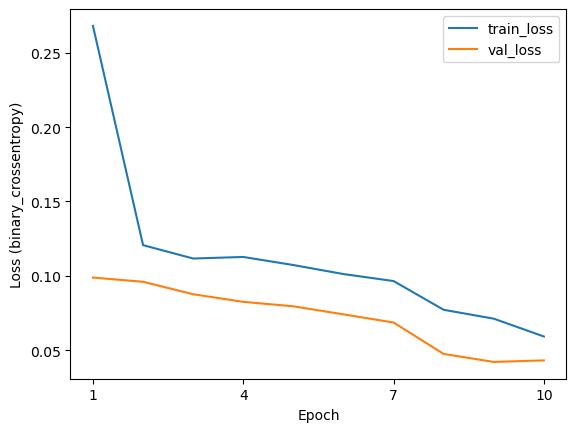

In [ ]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

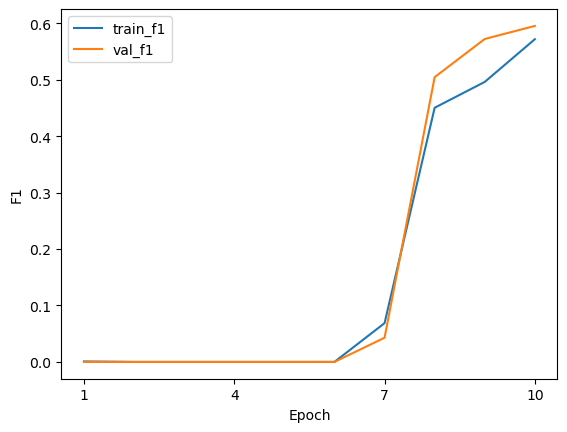

In [ ]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = hist2.history['f1']
val_f1 = hist2.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

In [ ]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(hist2.history['val_loss'])
best_val_f1 = max(hist2.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

1/1 [==============================] - 0s 30ms/step


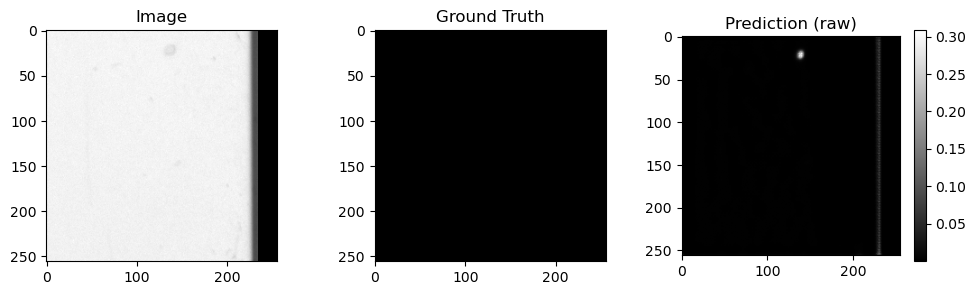

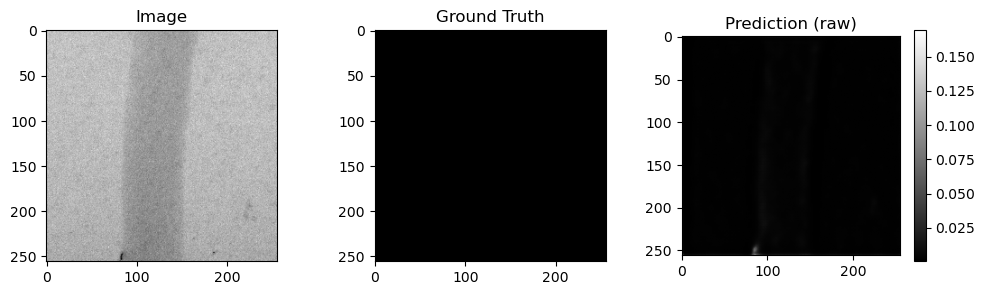

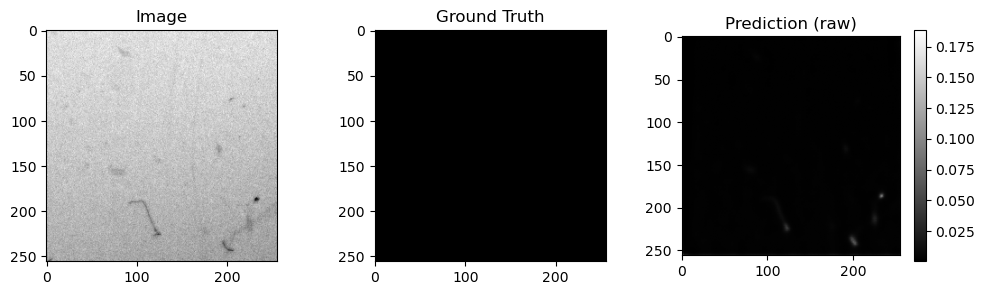

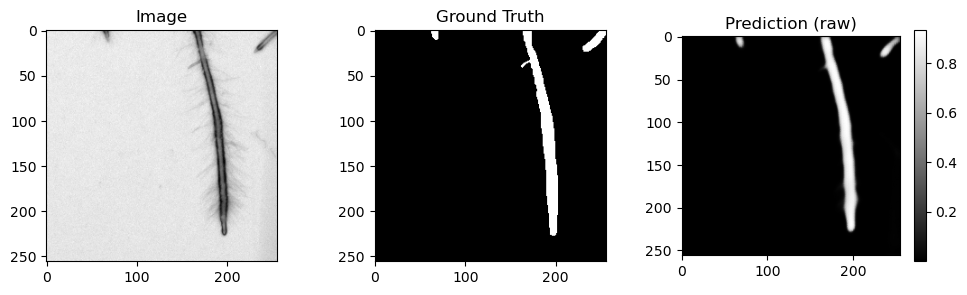

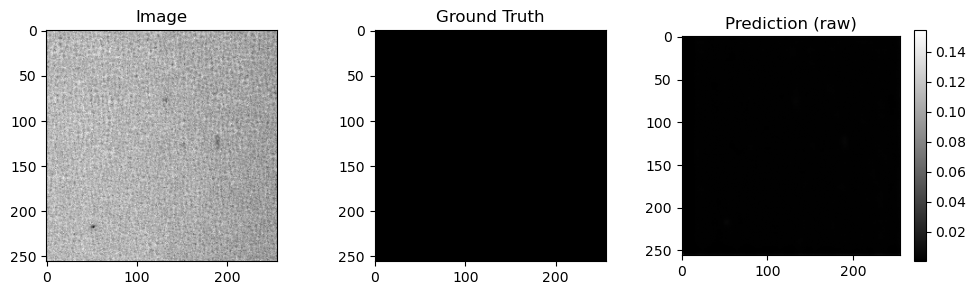

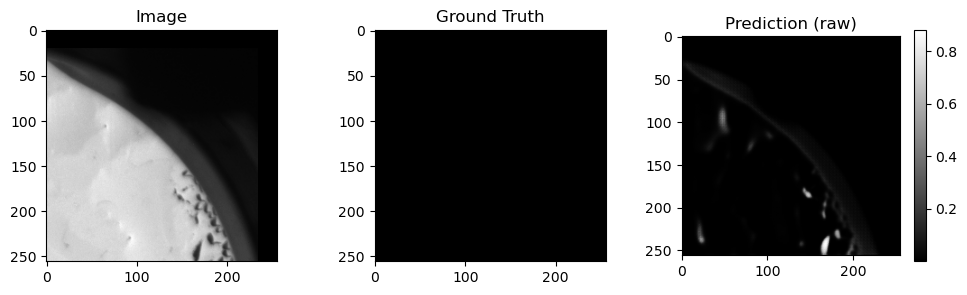

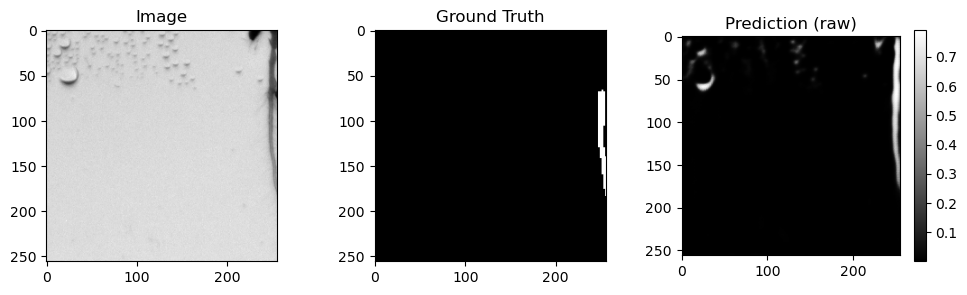

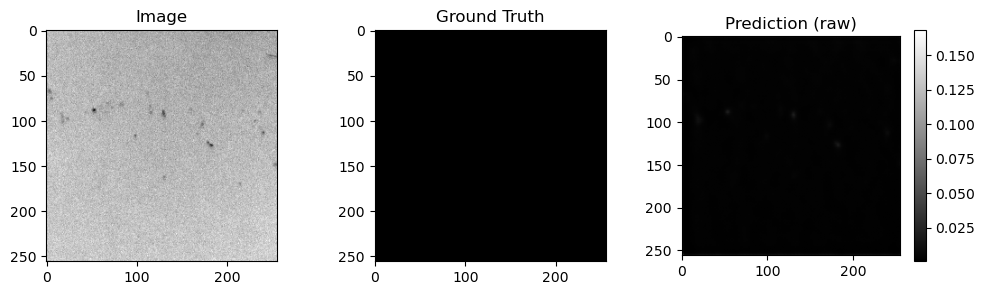

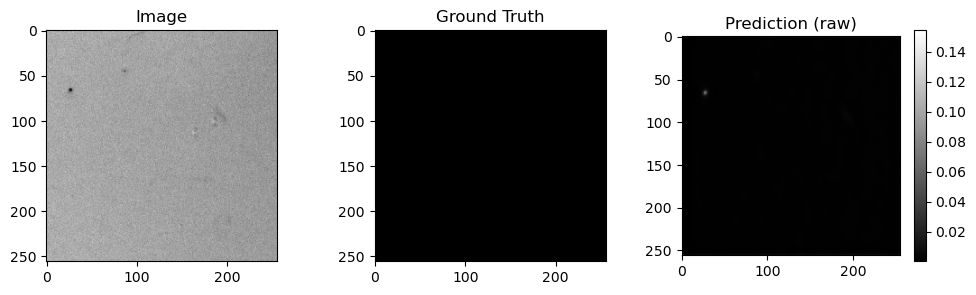

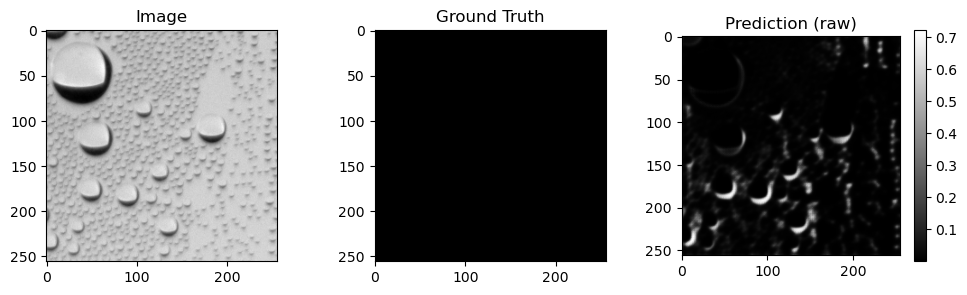

In [ ]:
import matplotlib.pyplot as plt

images, masks = next(val_generator)
preds = model.predict(images)

for i in range(10):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(images[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(masks[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction (raw)")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.colorbar()
    plt.show()
